In [1]:
import pandas as pd
pd.options.mode.copy_on_write = True
import json
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from collections import defaultdict
from nltk.stem import WordNetLemmatizer

In [2]:
df = pd.read_csv('data/spam.csv', encoding='Windows-1252')

### Cleaning data first

repeat of cleaning from data preprocessing

In [3]:
## drop unnamed and empty columns
df = df.loc[:, ~df.columns.str.contains('unnamed', case=False)]

# Regular expression pattern to match non-ASCII characters (mojibakes)
pattern = r'[^\x00-\x7F]'

# Remove all mojibake characters from the 'v2_cleaned' column
df['v2_cleaned'] = df['v2'].str.replace(pattern, '', regex=True)

# found some more
df['v2_cleaned'] = df['v2_cleaned'].str.replace('&lt;#&gt;', '')
df['v2_cleaned'] = df['v2_cleaned'].str.replace('&amp;', '')
df['v2_cleaned'] = df['v2_cleaned'].str.replace('&gt;', '')
df['v2_cleaned'] = df['v2_cleaned'].str.replace('&lt;', '')


df.head()

,v1,v2,v2_cleaned
0,ham,"Go until jurong point, crazy.. Available only ...","Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...","Nah I don't think he goes to usf, he lives aro..."


# Text Analysis pre-processing

## Remove Punctuation

In [4]:
# remove punctuation
df['v2_cleaned'] = df['v2_cleaned'].str.translate(str.maketrans('', '', string.punctuation))

df.head()

,v1,v2,v2_cleaned
0,ham,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...
1,ham,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...


### In R

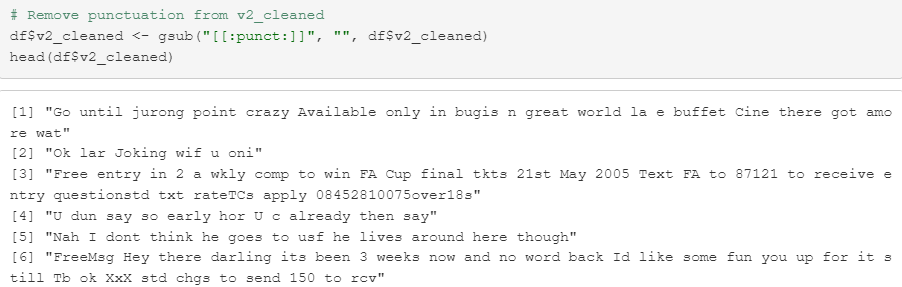

## Replace Text-Speak and Convert to Lowercase

In [5]:
with open('text_speak_dict.json', 'r') as file:
    text_speak_dict = json.load(file)

# Function to replace text-speak using the custom dictionary
def replace_text_speak(text, text_speak_dict):
    words = text.split()
    normalized_words = [text_speak_dict.get(word, word) for word in words]
    return ' '.join(normalized_words)

df['v2_cleaned'] = df['v2_cleaned'].apply(lambda x: replace_text_speak(x.lower(), text_speak_dict))

df.head()

,v1,v2,v2_cleaned
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking with you only
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in to a weekly comp to win fa cup f...
3,ham,U dun say so early hor... U c already then say...,you do not say so early hor you see already th...
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...


### In R

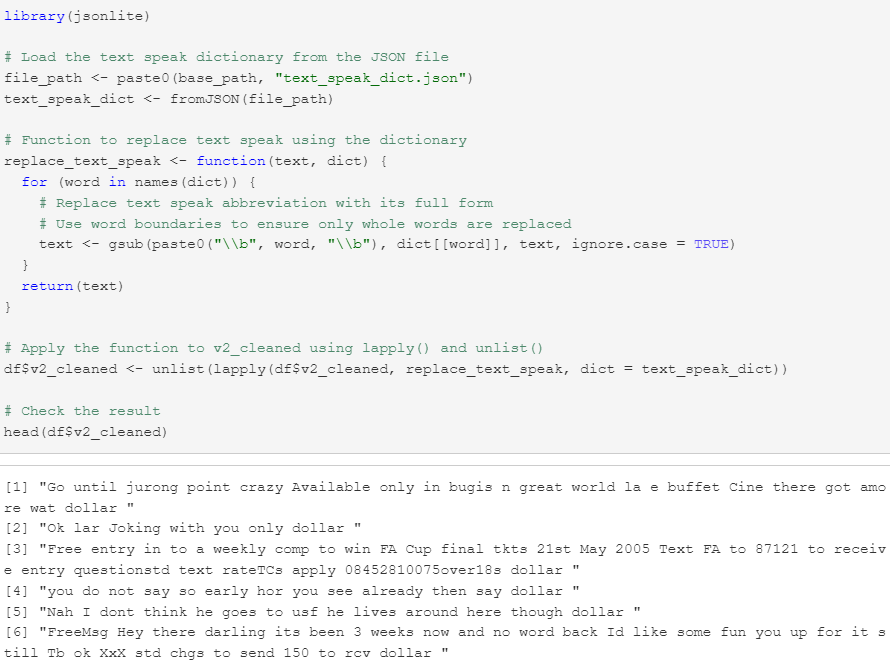

## Remove Singlish Emphasis Particles

In [6]:
# remove the Singlish emphasis particles

# List of Singlish particles to remove
singlish_particles = ['lah', 'lar', 'lor', 'meh', 'hor', 'leh', 'liao', 'mah', 'ah', 'la', 'wat']

# Function to remove Singlish particles
def remove_singlish_particles(text):
    words = text.split()
    return ' '.join([word for word in words if word not in singlish_particles])

# Apply the function to clean Singlish particles
df['v2_cleaned'] = df['v2_cleaned'].apply(remove_singlish_particles)

df.head()

,v1,v2,v2_cleaned
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,ok joking with you only
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in to a weekly comp to win fa cup f...
3,ham,U dun say so early hor... U c already then say...,you do not say so early you see already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...


### In R

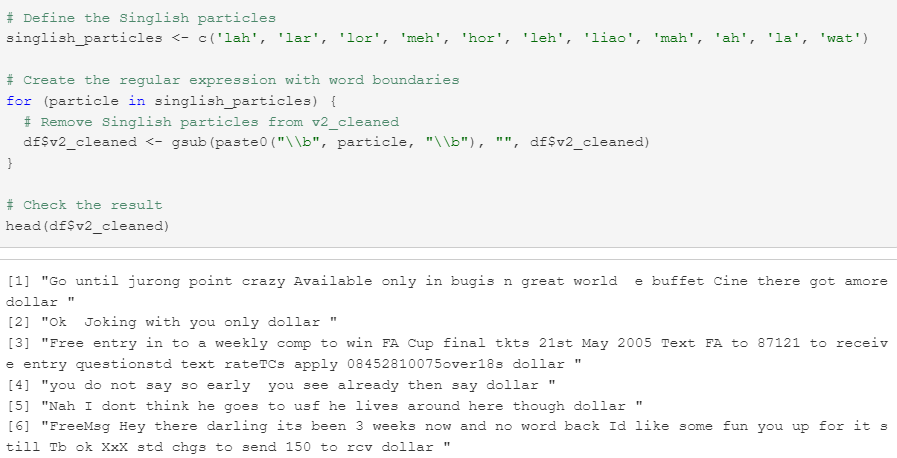

## Tokenise and Remove Stopwords

In [7]:
df['v2_tokens'] = df['v2_cleaned'].apply(nltk.word_tokenize)
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text if word not in stop_words])

df['v2_no_stops'] = df['v2_tokens'].apply(remove_stopwords)
df['v2_no_stops_tokens'] = df['v2_no_stops'].str.split()
df.head()

,v1,v2,v2_cleaned,v2_tokens,v2_no_stops,v2_no_stops_tokens
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...",go jurong point crazy available bugis n great ...,"[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,ok joking with you only,"[ok, joking, with, you, only]",ok joking,"[ok, joking]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in to a weekly comp to win fa cup f...,"[free, entry, in, to, a, weekly, comp, to, win...",free entry weekly comp win fa cup final tkts 2...,"[free, entry, weekly, comp, win, fa, cup, fina..."
3,ham,U dun say so early hor... U c already then say...,you do not say so early you see already then say,"[you, do, not, say, so, early, you, see, alrea...",say early see already say,"[say, early, see, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...",nah dont think goes usf lives around though,"[nah, dont, think, goes, usf, lives, around, t..."


### In R

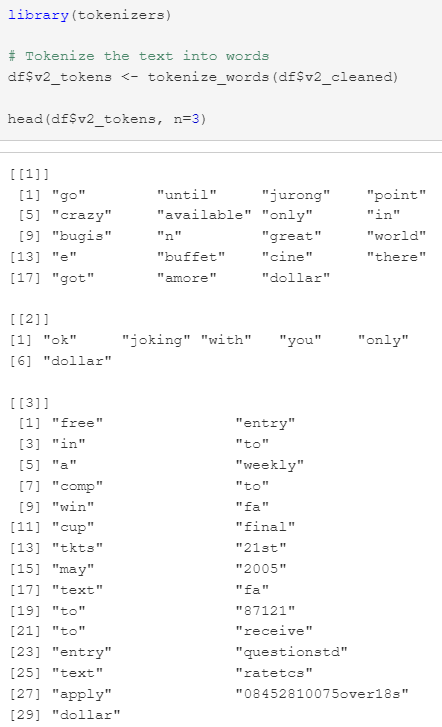

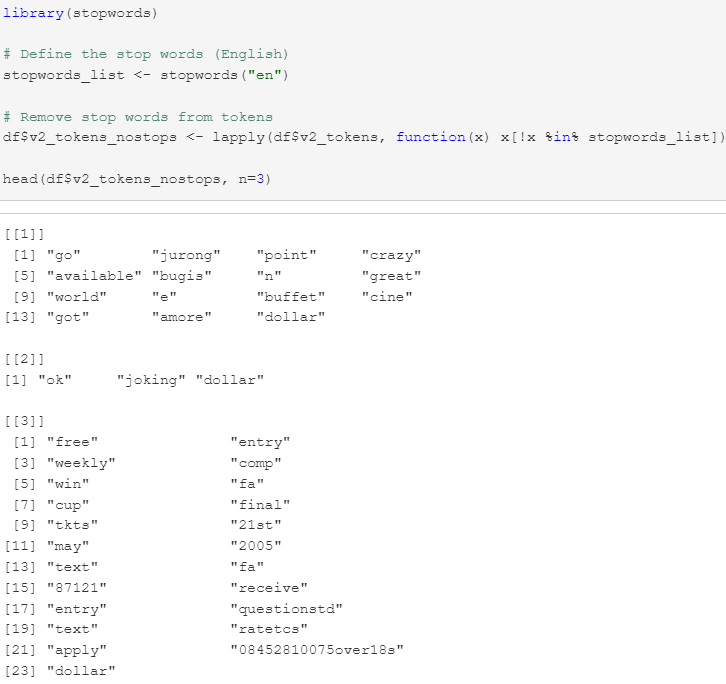

## Lemmatisation

In [8]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Apply lemmatization to the tokenized description
df['v2_no_stops_tokens_lem'] = df['v2_no_stops_tokens'].apply(lambda words: [lemmatizer.lemmatize(word) for word in words])

df.head()

,v1,v2,v2_cleaned,v2_tokens,v2_no_stops,v2_no_stops_tokens,v2_no_stops_tokens_lem
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...",go jurong point crazy available bugis n great ...,"[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,ok joking with you only,"[ok, joking, with, you, only]",ok joking,"[ok, joking]","[ok, joking]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in to a weekly comp to win fa cup f...,"[free, entry, in, to, a, weekly, comp, to, win...",free entry weekly comp win fa cup final tkts 2...,"[free, entry, weekly, comp, win, fa, cup, fina...","[free, entry, weekly, comp, win, fa, cup, fina..."
3,ham,U dun say so early hor... U c already then say...,you do not say so early you see already then say,"[you, do, not, say, so, early, you, see, alrea...",say early see already say,"[say, early, see, already, say]","[say, early, see, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...",nah dont think goes usf lives around though,"[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, go, usf, life, around, though]"


### In R

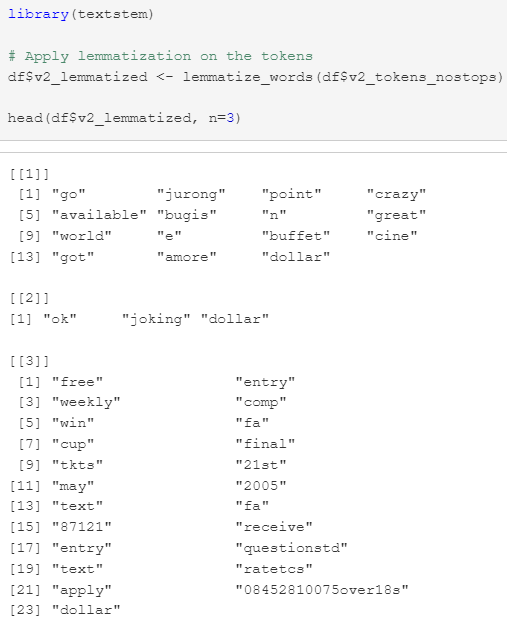

## Vocabulary of Terms

In [9]:
# function for making a vocabulary of terms
def make_vocab_of_terms(df, df_col):
    # Initialize a dictionary to store word frequency and indices
    vocab = defaultdict(lambda: {'count': 0, 'indices': []})

    # Iterate over each row and update word count and indices
    for idx, tokens in df[df_col].dropna().items():
        for word in tokens:
            vocab[word]['count'] += 1
            vocab[word]['indices'].append(idx)
    
    # Convert the dictionary to a DataFrame to display the result
    vocab_df = pd.DataFrame([(word, info['count'], info['indices']) for word, info in vocab.items()], 
                            columns=['Word', 'Count', 'Indices'])
    
    # Sort by word count in descending order
    vocab_df = vocab_df.sort_values(by='Count', ascending=False)

    return vocab_df

models = ['basic cleaned', 'no stop words', 'lemmatisation']
cols = ['v2_tokens', 'v2_no_stops_tokens', 'v2_no_stops_tokens_lem']

print(f"Vocabulary of Terms were made using {len(models)} different models: \n{', '.join(models)}")
for model, col in zip(models, cols):
    print(f'\n{model.title()}')
    word_df = make_vocab_of_terms(df, col)
    print(f'Number of words in Vocabulary of Terms: {len(word_df)}')
    print(f'Number of words with a frequency over 100 in Vocabulary of Terms: {len(word_df[word_df["Count"] > 100])}')
    print(f'Number of words with a frequency of 1 in Vocabulary of Terms: {len(word_df[word_df["Count"] == 1])}')
    print("Top 5 words")
    print(word_df.head(5).reset_index(drop=True))
    print("Bottom 5 words")
    print(word_df.tail(5).reset_index(drop=True))


Vocabulary of Terms were made using 3 different models: 
basic cleaned, no stop words, lemmatisation

Basic Cleaned
Number of words in Vocabulary of Terms: 9398
Number of words with a frequency over 100 in Vocabulary of Terms: 126
Number of words with a frequency of 1 in Vocabulary of Terms: 5127
Top 5 words
  Word  Count                                            Indices
0  you   3252  [1, 3, 3, 5, 8, 9, 12, 13, 13, 17, 18, 20, 23,...
1   to   2724  [2, 2, 2, 2, 4, 5, 5, 6, 7, 8, 8, 9, 9, 10, 11...
2    i   2266  [4, 10, 13, 13, 14, 17, 17, 23, 23, 24, 25, 29...
3    a   1438  [2, 8, 12, 13, 14, 25, 27, 33, 40, 42, 48, 49,...
4  the   1333  [9, 9, 12, 13, 15, 15, 18, 18, 19, 27, 28, 33,...
Bottom 5 words
          Word  Count Indices
0     box61m60      1  [2052]
1    gbp5month      1  [2052]
2         cast      1  [2052]
3  09094100151      1  [2052]
4     bitching      1  [5570]

No Stop Words
Number of words in Vocabulary of Terms: 9267
Number of words with a frequency over 100 in 

### In R

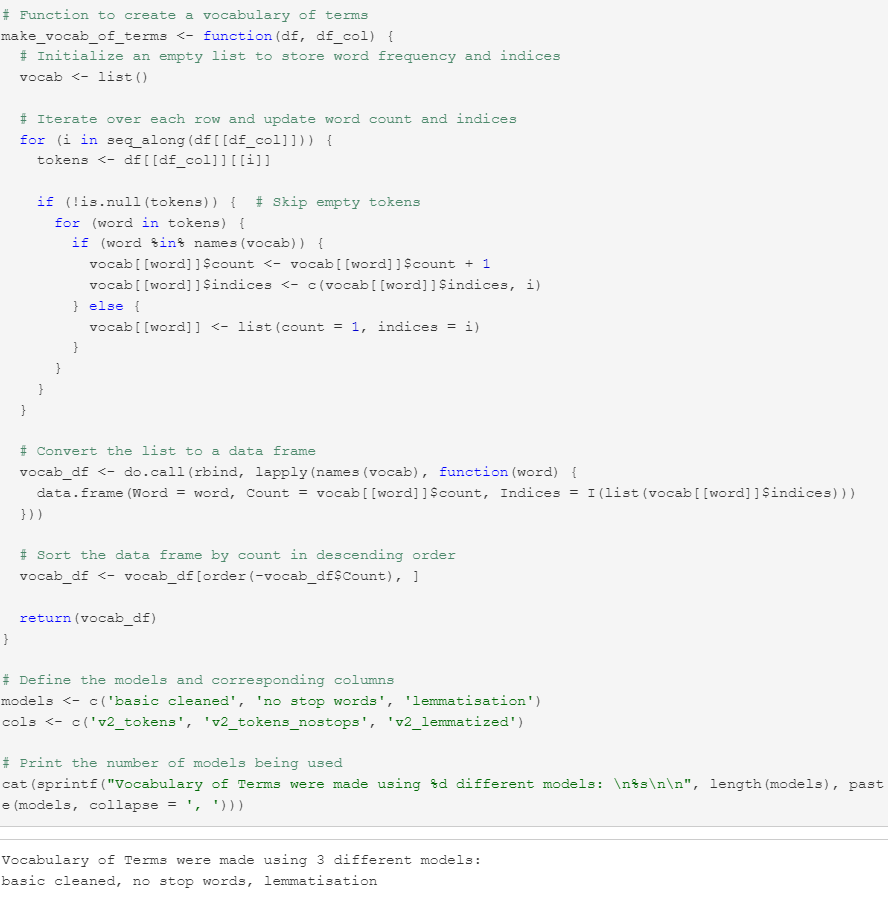
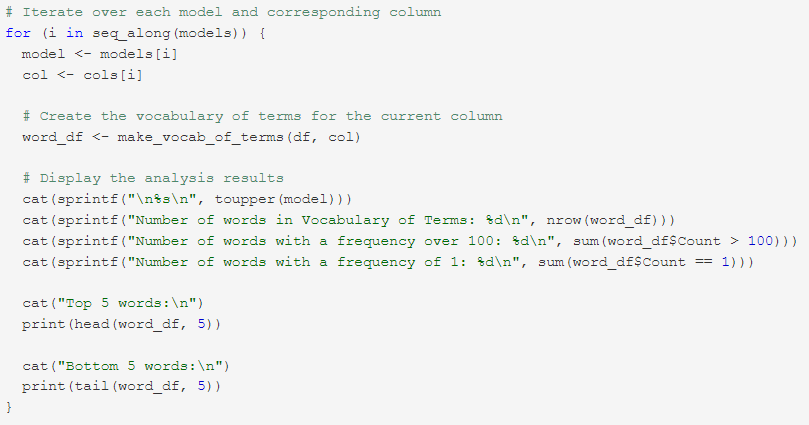
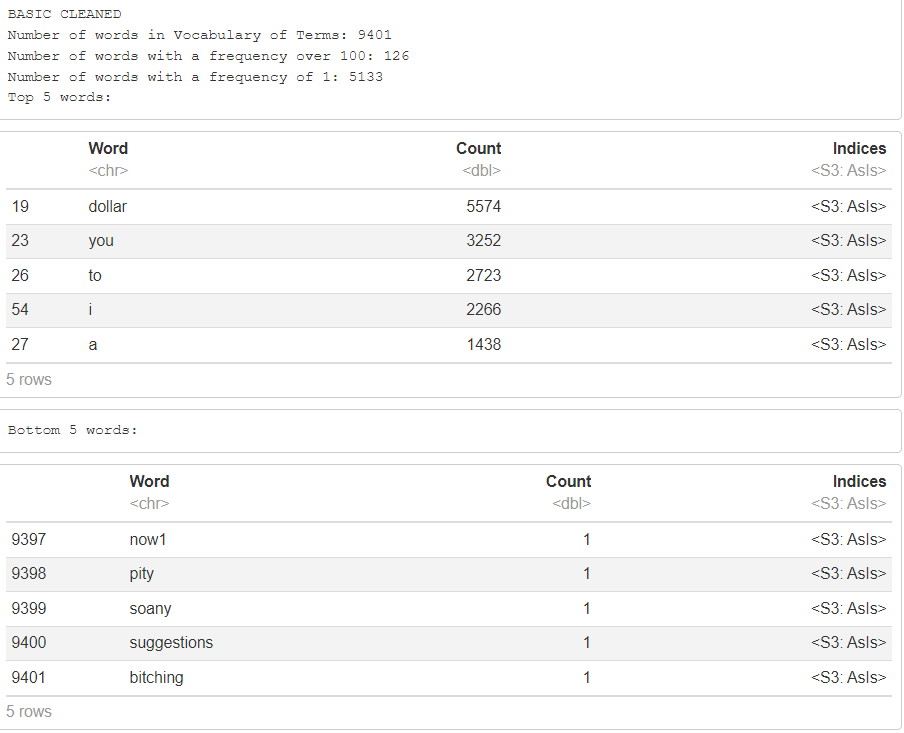
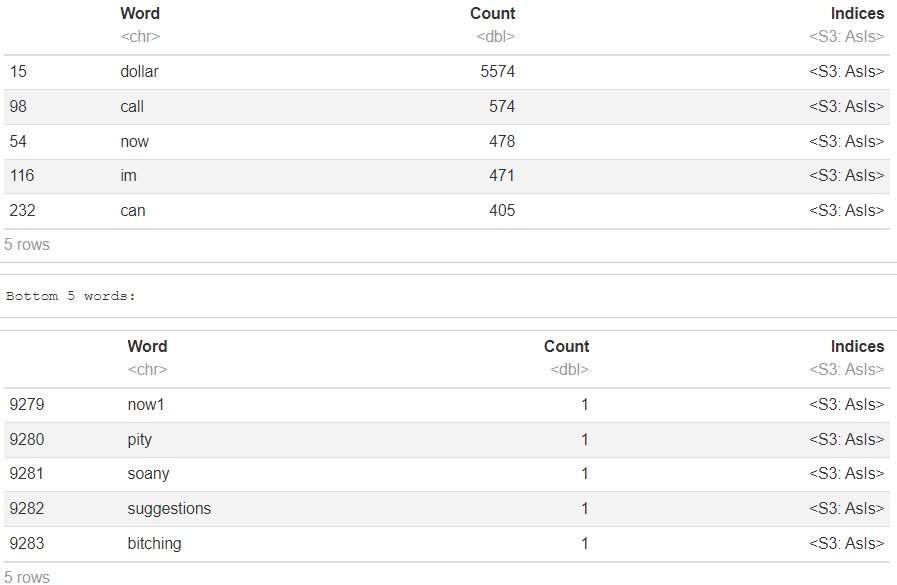
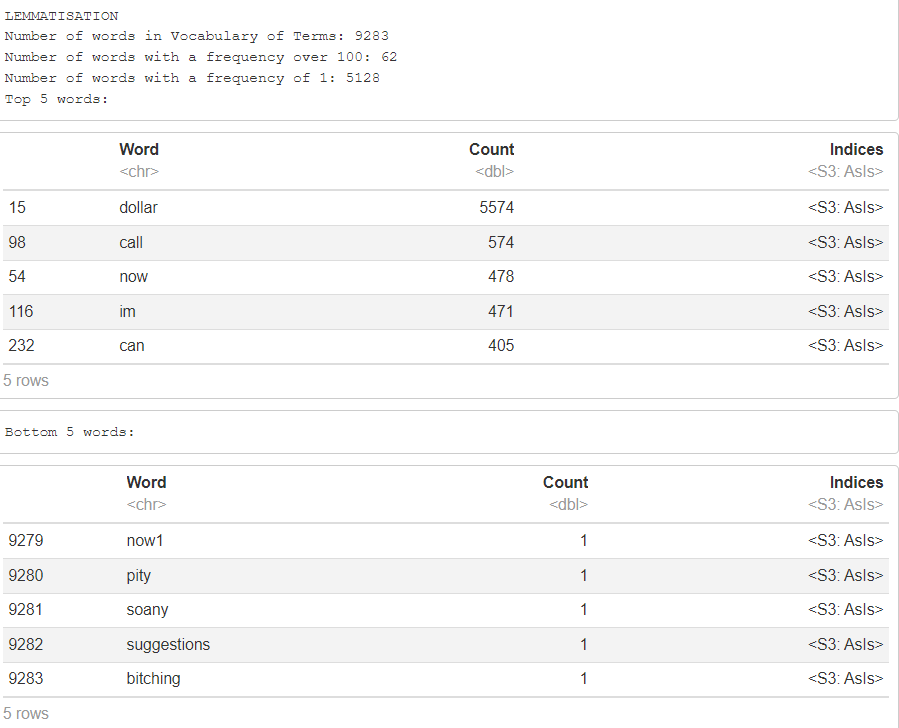

The top words are fairly similar to those from python, though there is a huge count for the word 'dollar' in R (5574) that doesn't appear at all in python and I am unsure why. The other difference is that lemmatisation had no effect in R, while it did in python.

### Comparison with WEKA

The majority of this is not possible in WEKA. WEKA has a StringToWordVector filter that can tokenise strings, but it was impossible to test this as the file could not be converted to a readable arff file.